In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [76]:
DATASET_PATH = "/home/matv864/it/AI_work/data/convictions.csv"

In [77]:
dataset  = pd.read_csv(DATASET_PATH)

# start cleaning dataset

In [78]:
# clean "Legally Exonerated", "Legally Exonerated Encoded"

print((
    dataset['Legally Exonerated'].map({"yes": 1, "no": 0})
    ==
    dataset['Legally Exonerated Encoded']
).unique())
dataset = dataset.drop("Legally Exonerated", axis=1)
dataset = dataset.rename(columns={'Legally Exonerated Encoded': 'Legally Exonerated'})


[ True]


In [79]:
# clean "Punishment for a crime"

print(dataset["Punishment for a crime"].unique())

def convert_punishment(punishment):

    if pd.isna(punishment) or punishment in ['community service', 'not sentenced',
                                           'probation', 'present']:
        return 0

    if 'death' in punishment.lower():
        return 200

    if 'life' in punishment.lower() or 'parole' in punishment.lower():
        return 100

    if '-' in punishment:
        years = punishment.split('-')[1].strip().split()[0]
        return int(float(years) * 12)

    if 'years' in punishment:
        parts = punishment.replace(',', '').split()
        for part in parts:
            if part.replace('.', '').isdigit():
                return int(float(part) * 12)

    if 'months' in punishment:
        return int(punishment.split()[0])

    if punishment == 'probation, lifetime sex offender registration':
        return 0

    return 0

dataset['Punishment for a crime'] = (
    dataset['Punishment for a crime']
    .apply(convert_punishment)
)
dataset.head()

['death' '15 years' nan 'life in prison' '5 years' 'life without parole'
 '25 years' '20 years' '50 years'
 'death for Jimerson and Williams, 75 years for Adams, and life for Rainge'
 '75 years' '30 years' '40 years' '32 years' '63 years' '45 years'
 '33 years' '35 years' '11-35 years' '84 years' '49 years' '10 years'
 '7 years' '57 years' '60 years' 'community service' '8 years' '65 years'
 '55 years' '17 years' 'probation, lifetime sex offender registration'
 '6 years' '22 years' 'present' '21 years' '0.5 years' '4 years'
 '1.2 year' '16 years' '26 years' '12.5 years' 'not sentenced' '9 months']


,Unnamed: 0,Date of the Crime,Defendants,Type of the Crime,Location of the Crime,Punishment for a crime,Legally Exonerated
0,0,1805,Dominic Daley and James Halligan,murder,Massachusetts,200,1
1,1,1843,John Gordon,murder,Rhode Island,200,1
2,2,1855,Chief Leschi,murder,Washington,200,0
3,3,1863,Chipita Rodriguez,murder,Texas,200,1
4,4,1872,William Jackson Marion,murder,Nebraska,200,1


In [80]:
# clean "Date of the Crime"

print(dataset["Date of the Crime"].unique())
# nothing to clean

[1805 1843 1855 1863 1872 1886 1887 1894 1896 1900 1906 1912 1913 1916
 1920 1931 1932 1936 1944 1957 1961 1965 1966 1967 1971 1972 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2016 2017]


In [81]:
# clean "Defendants"

print(dataset["Defendants"].unique())

def split_defendants(text):
    text = text.replace("\xa0", " ").replace(".", "")
    separators = r'\s+(?:and|&|,|;)\s+'
    return re.split(separators, text)

dataset['Defendants'] = (
    dataset['Defendants']
    .str.strip()
    .str.lower()
    .apply(split_defendants)
)


['Dominic Daley\xa0and\xa0James Halligan' 'John Gordon' 'Chief Leschi'
 'Chipita Rodriguez' 'William Jackson Marion'
 'Oscar Neebe,\xa0August Spies, and\xa0Albert Parsons' 'Charles Hudspeth'
 'George Washington Davis' 'Jack Davis' 'Caleb Powers' 'Ed Johnson'
 'Bill Wilson' 'Thomas Griffin and Meeks Griffin' 'Leo Frank'
 'Thomas Mooney' 'Nicola Sacco and Bartolomeo Vanzet' 'Scottsboro Boys'
 'Joseph Majczek and Theodore Marcinkiewicz' 'Joe Arridy' 'George Stinney'
 'Jack McCullough' 'Clarence Earl Gideon' 'Muhammad Aziz and Khalil Islam'
 'Rubin Carter' 'James Joseph Richardson' 'Richard Phillips'
 'Anthony Mazza' 'Wilbert Jones' 'Gregory Bright' 'Delbert Tibbs'
 'Michael Lloyd Self' 'David Bryant' 'Ledura Watkins'
 'Ricky Jackson, Ronnie Bridgeman, and Wiley Bridgeman'
 'Clifford Williams, Jr' 'Charles Ray Finch' 'Lewis Fogle'
 'Randall Dale Adams' 'Dewey Bozella' 'Brian Baldwin' 'Gary Dotson'
 'The Ford Heights Four, Verneal Jimerson, Dennis Williams, Kenneth Adams and Willie Rainge'


In [82]:
# clean "Type of the Crime"

print(dataset["Type of the Crime"].unique())

crime_categories = {
    **dict.fromkeys(['murder',
        'manslaughter',
        'manslaughter of infant',
        'drive-by shooting',
        'attempted murder',
        'felony assault of a child',
        'assault',
        'child abuse'],'Violent Crimes Against Persons'),
    **dict.fromkeys(['rape',
        'sexual assault',
        'child sexual abuse',
        'sexual abuse of children',
        'child sex abuse',
        'satanic ritual sex abuse',
        'criminal sexual conduct',
        'sodomy',
        'rape, murder',
        'rape,  murder',
        'sexual assault, sexual abuse, kidnapping, robbery',
        'sexual assault, kidnapping'],'Sexual Offenses'),
    **dict.fromkeys(['robbery',
        'burglary',
        'theft',
        'petty theft',
        'armed robbery',
        'carjacking',
        'arson',
        'breaking and entering',
        'breaking and entering, petty theft',
        'robbery, other violent felony'],'Property Crimes'),
    **dict.fromkeys(['weapon possession or sale',
        'illegal use of a weapon',
        'murder, robbery, illegal use of a weapon',
        'murder, gun possession or sale and conspiracy',
        'robbery, assault, illegal use of a weapon'],'Weapon-Related Crimes'),
    **dict.fromkeys(['murder, robbery',
        'murder, robbery, burglary',
        'rape, kidnapping',
        'rape, sodomy, robbery',
        'rape, robbery',
        'murder, carjacking',
        'murder, assault, illegal use of a weapon',
        'attempted murder, robbery, assault, kidnapping',
        'murder, other violent felony, conspiracy'],'Compound Violent Felonies'),
    **dict.fromkeys(['filing a false report',
        'fraud',
        'conspiracy'],'Crimes Against Justice'),
    **dict.fromkeys(['haymarket affair',
        'sabotage of Locomotive 213',
        'preparedness Day Bombing'],'Historical/Political Cases'),

    **dict.fromkeys(['robbery, rape',
        'assault, rape',
        'murder, rape',
        'criminal sexual conduct, armed robbery',
        'sexual assault, robbery, other violent felony'],'Multi-Crime Incidents')
}


dataset['Type of the Crime'] = dataset['Type of the Crime'].map(crime_categories)


['murder' 'haymarket affair' 'sabotage of Locomotive 213' 'rape'
 'preparedness Day Bombing' 'breaking and entering, petty theft'
 'sexual assault' 'robbery, rape' 'murder, robbery'
 'satanic ritual sex abuse' 'rape,  murder' 'assault, rape'
 'murder, robbery, burglary' 'rape, sodomy, robbery' 'rape, robbery'
 'child sexual abuse' 'sexual abuse of children'
 'murder, robbery, illegal use of a weapon' 'murder, carjacking'
 'sexual assault, sexual abuse, kidnapping, robbery' 'rape, kidnapping'
 'sexual assault, robbery, other violent felony' 'drive-by shooting'
 'rape, murder' 'criminal sexual conduct, armed robbery'
 'filing a false report' 'murder, rape' 'sexual assault, kidnapping'
 'child abuse' 'manslaughter' 'manslaughter of infant' 'child sex abuse'
 'weapon possession or sale' 'robbery, assault, illegal use of a weapon'
 'robbery' 'murder, assault, illegal use of a weapon' 'fraud'
 'felony assault of a child'
 'attempted murder, robbery, assault, kidnapping'
 'murder, other viole

In [83]:
# clean "Location of the Crime"

print(dataset["Location of the Crime"].unique())

states_regions = {
    **dict.fromkeys(['Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'New Jersey', 'Pennsylvania'], 'Northeast'),
    **dict.fromkeys(['Illinois', 'Nebraska', 'Michigan', 'Ohio', 'Wisconsin', 'Missouri', 'Iowa', 'Indiana', 'Kansas'], 'Midwest'),
    **dict.fromkeys(['Texas', 'Arkansas', 'Louisiana', 'Oklahoma', 'Alabama', 'South Carolina',
         'Georgia', 'Florida', 'Tennessee', 'North Carolina', 'Virginia', 'Maryland',
         'Mississippi', 'Kentucky', 'West Virginia'], 'South'),
    **dict.fromkeys(['Washington', 'California', 'Colorado', 'Idaho', 'Nevada', 'Oregon', 'Arizona', 'Montana'], 'West')
}

dataset['Location of the Crime'] = dataset['Location of the Crime'].map(states_regions)

['Massachusetts' 'Rhode Island' 'Washington' 'Texas' 'Nebraska' 'Illinois'
 'Arkansas' 'Idaho' 'Kentucky' 'Tennessee' 'Alabama' 'South Carolina'
 'Georgia' 'California' 'Colorado' 'Florida' 'New York' 'New Jersey'
 'Michigan' 'Louisiana' 'Ohio' 'North Carolina' 'Pennsylvania' 'Missouri'
 'Nevada' 'Virginia' 'Oklahoma' 'Maryland' 'Wisconsin' 'Oregon'
 'West Virginia' 'Connecticut' 'Mississippi' 'Arizona' 'Iowa' 'Indiana'
 'Montana' 'Kansas']


In [84]:
dataset.head(10)

,Unnamed: 0,Date of the Crime,Defendants,Type of the Crime,Location of the Crime,Punishment for a crime,Legally Exonerated
0,0,1805,"[dominic daley, james halligan]",Violent Crimes Against Persons,Northeast,200,1
1,1,1843,[john gordon],Violent Crimes Against Persons,Northeast,200,1
2,2,1855,[chief leschi],Violent Crimes Against Persons,West,200,0
3,3,1863,[chipita rodriguez],Violent Crimes Against Persons,South,200,1
4,4,1872,[william jackson marion],Violent Crimes Against Persons,Midwest,200,1
5,5,1886,"[oscar neebe, august spies,, albert parsons]",Historical/Political Cases,Midwest,180,1
6,6,1887,[charles hudspeth],Violent Crimes Against Persons,South,200,1
7,7,1894,[george washington davis],Historical/Political Cases,Midwest,0,1
8,8,1896,[jack davis],Violent Crimes Against Persons,West,200,1
9,9,1900,[caleb powers],Violent Crimes Against Persons,South,0,1


# cleaning is end

In [85]:
dataset = dataset.drop(['Legally Exonerated', 'Unnamed: 0', 'Defendants'], axis=1)

In [86]:
dataset = pd.get_dummies(dataset, columns=["Type of the Crime", "Location of the Crime"])

In [87]:
dataset.head(10)

,Date of the Crime,Punishment for a crime,Type of the Crime_Compound Violent Felonies,Type of the Crime_Crimes Against Justice,Type of the Crime_Historical/Political Cases,Type of the Crime_Multi-Crime Incidents,Type of the Crime_Property Crimes,Type of the Crime_Sexual Offenses,Type of the Crime_Violent Crimes Against Persons,Type of the Crime_Weapon-Related Crimes,Location of the Crime_Midwest,Location of the Crime_Northeast,Location of the Crime_South,Location of the Crime_West
0,1805,200,False,False,False,False,False,False,True,False,False,True,False,False
1,1843,200,False,False,False,False,False,False,True,False,False,True,False,False
2,1855,200,False,False,False,False,False,False,True,False,False,False,False,True
3,1863,200,False,False,False,False,False,False,True,False,False,False,True,False
4,1872,200,False,False,False,False,False,False,True,False,True,False,False,False
5,1886,180,False,False,True,False,False,False,False,False,True,False,False,False
6,1887,200,False,False,False,False,False,False,True,False,False,False,True,False
7,1894,0,False,False,True,False,False,False,False,False,True,False,False,False
8,1896,200,False,False,False,False,False,False,True,False,False,False,False,True
9,1900,0,False,False,False,False,False,False,True,False,False,False,True,False


# start build classification

In [88]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

In [89]:
wcss = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=777)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

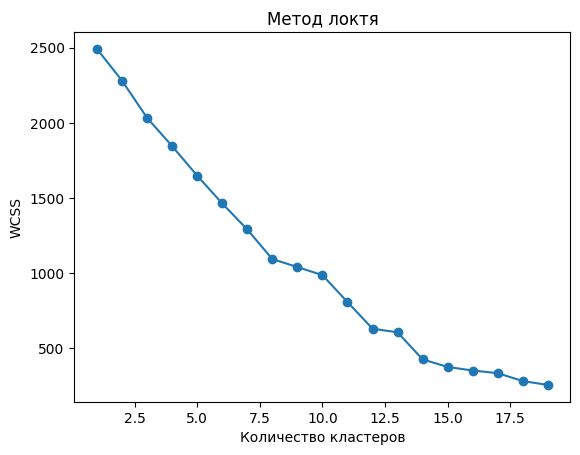

In [90]:
plt.plot(range(1, 20), wcss, marker="o")
plt.xlabel("Количество кластеров")
plt.ylabel("WCSS")
plt.title("Метод локтя")
plt.show()

In [91]:
kmeans = KMeans(n_clusters=14, init='k-means++', random_state=777)
kmeans.fit(scaled_data)

KMeans(n_clusters=14, random_state=777)

In [92]:
clusters = kmeans.fit_predict(scaled_data)

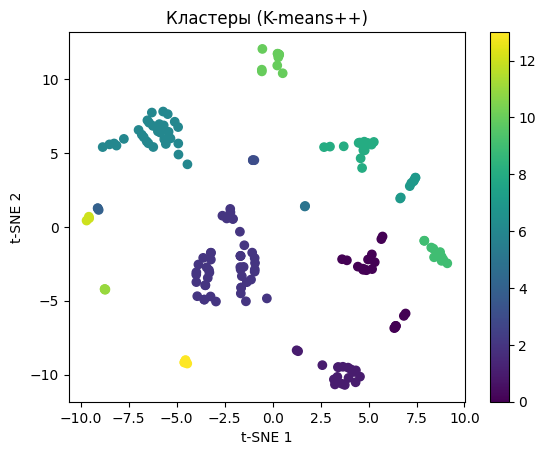

In [93]:
tsne = TSNE(n_components=2, random_state=1984)
projected_data = tsne.fit_transform(scaled_data)

plt.scatter(projected_data[:, 0], projected_data[:, 1], c=clusters, cmap="viridis")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("Кластеры (K-means++)")
plt.colorbar()
plt.show()

In [94]:
dataset['Cluster'] = clusters
cluster_stats = dataset.groupby('Cluster').mean()
cluster_stats

,Date of the Crime,Punishment for a crime,Type of the Crime_Compound Violent Felonies,Type of the Crime_Crimes Against Justice,Type of the Crime_Historical/Political Cases,Type of the Crime_Multi-Crime Incidents,Type of the Crime_Property Crimes,Type of the Crime_Sexual Offenses,Type of the Crime_Violent Crimes Against Persons,Type of the Crime_Weapon-Related Crimes,Location of the Crime_Midwest,Location of the Crime_Northeast,Location of the Crime_South,Location of the Crime_West
Cluster,,,,,,,,,,,,,,
0,1983.150000,256.100000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.350000,0.650000,0.000000
1,1963.222222,180.888889,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,1.000000,0.000000,0.000000
2,1975.239130,159.652174,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,1.000000,0.000000
3,1898.666667,126.666667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.000000,0.000000,0.333333
4,1989.333333,66.666667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.666667,0.333333,0.000000,0.000000
5,2004.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.500000,0.000000,0.500000
6,1984.800000,179.066667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.000000,0.000000,0.000000,0.000000
7,1997.250000,235.500000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000
8,1971.142857,197.142857,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,1.000000
